In this notebook file, I will use my own model to finish two part of work:
First Part - Layout Recognition: Use ViT to extract main text
Second Part - OCR: Recognize the text correctly

In the notebook, the content of whole training and validation process is shown below:
0. The environment setup

2. Use ViT to detect main text
3. Crop the main text
4. OCR Recognition
5. Validation

# 2. Use ViT to detect main text

# 1.1 从 JSON + 原图生成分割掩码（mask）
# 1.2 编写一个 PyTorch Dataset，让它一次性返回 (image, mask)
# 1.3 切分成训练集、验证集、测试集（如果数据足够多的话）

现在已经有了mask文件，经过可视化检查确定没有问题
然后可以正式进入模型训练阶段了
用image，mask数据来训练一个文本区域分割模型，让它学会自动预测哪些像素属于文本。

1、准备分割数据集（使用离线mask）

In [23]:
import os
import cv2
import numpy as np
import torch
from torch.utils.data import Dataset
import torchvision.transforms as T
from PIL import Image

class ImageMaskDataset(Dataset):
    def __init__(self, img_dir, mask_dir, transform=None):
        """
        img_dir : 原图目录 (data/annotation_images)
        mask_dir: 离线生成的mask目录 (data/mask)
        transform: 对图像做的变换 (同时也要对mask做相应变换)
        """
        super().__init__()
        self.img_dir = img_dir
        self.mask_dir = mask_dir
        self.transform = transform
        
        # 收集原图文件名
        self.img_files = [f for f in os.listdir(img_dir) 
                          if f.lower().endswith('.png') or f.lower().endswith('.jpg')]
        self.img_files.sort()
    
    def __len__(self):
        return len(self.img_files)
    
    def __getitem__(self, idx):
        # 假设 img_name = "3_page_001.png"
        img_name = self.img_files[idx]
        base_name = img_name.rsplit('.', 1)[0]
        
        # mask 文件名 = base_name + "_mask.png"
        mask_name = base_name + "_mask.png"
        
        img_path  = os.path.join(self.img_dir,  img_name)
        mask_path = os.path.join(self.mask_dir, mask_name)
        
        # 读取原图 (BGR -> RGB)
        img_bgr = cv2.imread(img_path)
        img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
        
        # 读取mask (灰度)
        mask_gray = cv2.imread(mask_path, cv2.IMREAD_UNCHANGED)
        
        # 将它们转为 PIL 形式
        img_pil = Image.fromarray(img_rgb)
        # 对于 mask，如果是 0/255，可以保持不变；如果是 0/1，也能一样处理
        mask_pil = Image.fromarray(mask_gray)
        
        if self.transform:
            # 对图像做 transform
            img_t = self.transform(img_pil)
            
            # 对 mask 同样做变换 (如果 transform 包含Resize/Crop等)
            # 注意最好用最近邻插值，以免把 0/255 变成中间值
            # 这里简单示例：如果 transform 仅仅是 ToTensor，就分别处理
            mask_t = T.ToTensor()(mask_pil)
        else:
            img_t = T.ToTensor()(img_pil)
            mask_t = T.ToTensor()(mask_pil)
        
        # 如果你的 mask 是 0/255，你可能需要将其归一化为0/1：
        # mask_t = (mask_t > 0.5).float()
        
        return img_t, mask_t


2、划分训练集、验证集、测试集

In [24]:
import os
import cv2
import numpy as np
import torch
from torch.utils.data import Dataset
import torchvision.transforms as T
from PIL import Image

class ImageMaskDataset(Dataset):
    """
    从离线掩码中读取 (image, mask) 的数据集。
    假设：
    - 原图目录: img_dir
    - 掩码目录: mask_dir
    - 每张原图对应一个同名 + '_mask.png' 的掩码文件
    
    例如:
      3_page_001.png  <---> 3_page_001_mask.png
    """
    def __init__(self, img_dir, mask_dir, transform=None):
        super().__init__()
        self.img_dir = img_dir
        self.mask_dir = mask_dir
        self.transform = transform
        
        # 收集所有图像文件名
        self.img_files = []
        for f in os.listdir(img_dir):
            if f.lower().endswith(('.png', '.jpg', '.jpeg')):
                self.img_files.append(f)
        self.img_files.sort()
    
    def __len__(self):
        return len(self.img_files)
    
    def __getitem__(self, idx):
        img_name = self.img_files[idx]
        base_name = img_name.rsplit('.', 1)[0]
        
        img_path = os.path.join(self.img_dir, img_name)
        mask_name = base_name + "_mask.png"
        mask_path = os.path.join(self.mask_dir, mask_name)
        
        # 读取原图 (BGR -> RGB)
        img_bgr = cv2.imread(img_path)
        img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
        
        # 读取掩码 (灰度)
        mask_gray = cv2.imread(mask_path, cv2.IMREAD_UNCHANGED)
        
        # 转为 PIL
        img_pil  = Image.fromarray(img_rgb)
        mask_pil = Image.fromarray(mask_gray)

        if self.transform:
            # 对图像使用用户传进来的 transform（假设包含 Resize + ToTensor）
            img_t = self.transform(img_pil)
            
            # 对掩码，需要**最近邻插值**的 Resize
            # 下面这行会将 mask resize 到 (224,224)，并使用最近邻
            mask_resized = T.Resize((224,224), interpolation=T.InterpolationMode.NEAREST)(mask_pil)
            mask_t = T.ToTensor()(mask_resized)
        else:
            # 如果没有 transform，就直接 ToTensor
            img_t = T.ToTensor()(img_pil)
            mask_t = T.ToTensor()(mask_pil)
        
        # 如果 mask 是 0/255，则可以转成 0/1
        mask_t = (mask_t > 0.5).float()
        
        return img_t, mask_t


# ==================== 划分数据集 ====================
if __name__ == "__main__":
    img_dir = "data/annotation_images"
    mask_dir = "data/mask"
    
    # 这里你可以加上 resize 等操作
    transform = T.Compose([
        T.Resize((224,224)),
        T.ToTensor()
    ])
    
    full_dataset = ImageMaskDataset(
        img_dir=img_dir,
        mask_dir=mask_dir,
        transform=transform
    )
    
    total_len = len(full_dataset)
    print(f"总共有 {total_len} 张图像 + 掩码。")

    # 以 12/3/3 为例
    train_size = 12
    val_size   = 3
    test_size  = total_len - train_size - val_size  # 若=3，则正好 12/3/3

    train_ds, val_ds, test_ds = random_split(
        full_dataset,
        [train_size, val_size, test_size],
        generator=torch.Generator().manual_seed(42)  # 固定随机种子
    )
    
    print(f"训练集: {len(train_ds)} 张, 验证集: {len(val_ds)} 张, 测试集: {len(test_ds)} 张")


总共有 18 张图像 + 掩码。
训练集: 12 张, 验证集: 3 张, 测试集: 3 张


对三个子集（12、3、3）分别创建dataloader，在训练、验证、测试环节使用

定义一个ViT分割模型（最小化示例）

In [25]:
import torch
import torch.nn as nn

class ViTSeg(nn.Module):
    def __init__(self,
                 image_size=224,
                 patch_size=16,
                 in_channels=3,
                 embed_dim=256,
                 num_heads=4,
                 num_layers=4,
                 mlp_ratio=4.0,
                 dropout=0.1,
                 num_classes=1):
        """
        一个多阶段上采样的 ViT 分割模型。
        
        参数：
        - image_size : 输入图像大小(假设宽高相同), 例如 224
        - patch_size : patch 大小, 例如 16
        - in_channels: 输入通道数(3=RGB)
        - embed_dim  : patch embedding 后的特征维度
        - num_heads  : 多头自注意力的头数
        - num_layers : Transformer Encoder 堆叠层数
        - mlp_ratio  : MLP隐层扩张倍数, feedforward 的维度是 embed_dim * mlp_ratio
        - dropout    : Transformer层的dropout
        - num_classes: 输出通道数 (对二分类分割来说一般=1)
        """
        super().__init__()
        self.image_size = image_size
        self.patch_size = patch_size
        
        # 下采样后每个维度多少个patch (如224/16=14)
        self.num_patches = (image_size // patch_size) * (image_size // patch_size)
        
        # ========== 1) Patch Embedding ==========
        # 用一个Conv2d模拟将图像分割成patch并映射到 embed_dim
        # kernel_size=patch_size, stride=patch_size => 空间下采样 16 倍
        self.patch_embed = nn.Conv2d(in_channels, embed_dim,
                                     kernel_size=patch_size,
                                     stride=patch_size)
        
        # ========== 2) 可学习的位置编码 ==========
        # shape: [1, num_patches, embed_dim]
        self.pos_embed = nn.Parameter(torch.zeros(1, self.num_patches, embed_dim))
        
        # ========== 3) Transformer Encoder ==========
        # 使用 PyTorch 自带的 nn.TransformerEncoderLayer
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=embed_dim,
            nhead=num_heads,
            dim_feedforward=int(embed_dim * mlp_ratio),
            dropout=dropout,
            activation='gelu',
            batch_first=True  # 让 (batch, seq, feature)
        )
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        
        # ========== 4) 多阶段上采样(分割头) ==========
        # 下采样后是 [B, embed_dim, H', W'], H'=W'=(224/16)=14
        # 我们要逐步 14->28->56->112->224 (4次 ×2=16倍)
        # 每阶段: 转置卷积( stride=2 ) + 卷积( kernel_size=3 ) + ReLU
        self.up_blocks = nn.Sequential(
            # 第1次上采样: 14->28
            nn.ConvTranspose2d(embed_dim, embed_dim//2, kernel_size=2, stride=2),
            nn.ReLU(),
            nn.Conv2d(embed_dim//2, embed_dim//2, kernel_size=3, padding=1),
            nn.ReLU(),
            
            # 第2次上采样: 28->56
            nn.ConvTranspose2d(embed_dim//2, embed_dim//4, kernel_size=2, stride=2),
            nn.ReLU(),
            nn.Conv2d(embed_dim//4, embed_dim//4, kernel_size=3, padding=1),
            nn.ReLU(),
            
            # 第3次上采样: 56->112
            nn.ConvTranspose2d(embed_dim//4, embed_dim//8, kernel_size=2, stride=2),
            nn.ReLU(),
            nn.Conv2d(embed_dim//8, embed_dim//8, kernel_size=3, padding=1),
            nn.ReLU(),
            
            # 第4次上采样: 112->224
            nn.ConvTranspose2d(embed_dim//8, embed_dim//8, kernel_size=2, stride=2),
            nn.ReLU(),
            nn.Conv2d(embed_dim//8, num_classes, kernel_size=1)
            # 如果二分类, num_classes=1 => 输出形状 [B,1,224,224]
        )
        
        # 如果你想在模型内部直接输出 [0,1] 概率, 可以再加一个 Sigmoid()
        # 不过通常在训练中, 我们用 BCEWithLogitsLoss, 不需要手动 sigmoid
        # self.final_act = nn.Sigmoid()
        
    def forward(self, x):
        """
        x: [B, in_channels, 224, 224] (假设输入是224×224)
        返回: [B, num_classes, 224, 224]
        """
        B, C, H, W = x.shape
        # ========== patch embedding ==========
        # => [B, embed_dim, H/16, W/16] => [B, embed_dim, 14, 14] (如果224/16=14)
        x = self.patch_embed(x)  # shape: [B, embed_dim, 14, 14]
        
        # ========== flatten + pos_embed ==========
        # => flatten到 [B, embed_dim, 196], 再转置到 [B, 196, embed_dim]
        x = x.flatten(2).transpose(1, 2)  # => [B, num_patches, embed_dim]
        # 加上可学习的位置编码
        x = x + self.pos_embed[:, :x.size(1), :]
        
        # ========== Transformer Encoder ==========
        # => [B, num_patches, embed_dim]
        x = self.transformer(x)
        
        # ========== reshape回 CNN 形式 ==========
        # => [B, embed_dim, 14, 14]
        x = x.transpose(1, 2)  # => [B, embed_dim, num_patches]
        # num_patches = 14*14=196
        # 重新变回 [B, embed_dim, 14, 14]
        Hp = H // self.patch_size  # 14
        Wp = W // self.patch_size  # 14
        x = x.view(B, -1, Hp, Wp)
        
        # ========== 多阶段上采样回 224×224 ==========
        x = self.up_blocks(x)  # => [B, num_classes, 224, 224]
        
        return x


# ========== 测试一下模型结构 ==========
if __name__ == "__main__":
    model = ViTSeg(
        image_size=224,
        patch_size=16,
        embed_dim=256,
        num_heads=4,
        num_layers=4,
        mlp_ratio=4.0,
        dropout=0.1,
        num_classes=1
    )
    dummy_input = torch.randn(2, 3, 224, 224)
    out = model(dummy_input)
    print("模型输出 shape:", out.shape)  # 期待 [2, 1, 224, 224]


模型输出 shape: torch.Size([2, 1, 224, 224])


编写训练循环

用 DataLoader 包装 train_ds、val_ds；
前向传播 -> 计算损失 -> 反向传播 -> 更新参数 -> 监控损失和验证集指标。

In [26]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import numpy as np

# ========== 定义一个 Dice 计算函数 ==========
def dice_coefficient(pred, target, threshold=0.5):
    """
    pred: 模型输出 (经过 sigmoid 后) 的概率图, shape [B, 1, H, W]
    target: 真实掩码, shape [B, 1, H, W], 取值0或1
    threshold: 二值化阈值, 默认0.5
    
    返回: 单个浮点数(平均Dice), 越接近1越好
    """
    # 先做二值化
    pred_bin = (pred > threshold).float()
    target_bin = (target > threshold).float()
    
    # 计算交集与并集
    intersection = (pred_bin * target_bin).sum()
    union = pred_bin.sum() + target_bin.sum()
    
    # 避免分母为0
    dice = (2.0 * intersection) / (union + 1e-6)
    return dice.item()

# ========== 准备训练 ==========

# 1. 选择使用 GPU 还是 CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# 2. 实例化模型并移动到 device
model = ViTSeg(
    image_size=224,
    patch_size=16,
    embed_dim=256,
    num_heads=4,
    num_layers=4,
    mlp_ratio=4.0,
    dropout=0.1,
    num_classes=1
).to(device)

# 3. 用 DataLoader 包装数据集
train_loader = DataLoader(train_ds, batch_size=2, shuffle=True,  num_workers=2)
val_loader   = DataLoader(val_ds,   batch_size=2, shuffle=False, num_workers=2)
test_loader  = DataLoader(test_ds,  batch_size=2, shuffle=False, num_workers=2)

# 4. 定义损失函数和优化器
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

# ========== 准备一些列表来存储日志 ==========
train_losses = []
val_losses   = []
val_dices    = []

# 5. 训练循环
epochs = 10
for epoch in range(epochs):
    # ========== 训练阶段 ==========
    model.train()
    total_train_loss = 0.0
    
    for imgs, masks in train_loader:
        imgs, masks = imgs.to(device), masks.to(device)
        
        # 前向传播
        outputs = model(imgs)  # [B,1,H,W], raw logits
        loss = criterion(outputs, masks)
        
        # 反向传播和参数更新
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        total_train_loss += loss.item()
    
    # 计算训练集平均 loss
    avg_train_loss = total_train_loss / len(train_loader)
    train_losses.append(avg_train_loss)
    
    # ========== 验证阶段 ==========
    model.eval()
    total_val_loss = 0.0
    total_val_dice = 0.0
    with torch.no_grad():
        for imgs, masks in val_loader:
            imgs, masks = imgs.to(device), masks.to(device)
            outputs = model(imgs)
            # 验证集上的 loss
            loss = criterion(outputs, masks)
            total_val_loss += loss.item()
            
            # 计算 Dice 系数
            # 先把 logits 过 sigmoid -> [0,1] 概率
            probs = torch.sigmoid(outputs)
            dice_val = dice_coefficient(probs, masks, threshold=0.5)
            total_val_dice += dice_val
    
    avg_val_loss = total_val_loss / len(val_loader)
    avg_val_dice = total_val_dice / len(val_loader)
    
    val_losses.append(avg_val_loss)
    val_dices.append(avg_val_dice)
    
    # 打印本 epoch 结果
    print(f"Epoch [{epoch+1}/{epochs}] "
          f"- Train Loss: {avg_train_loss:.4f} "
          f"- Val Loss: {avg_val_loss:.4f} "
          f"- Val Dice: {avg_val_dice:.4f}")
    
    # 如果训练集Loss明显低于验证集Loss, 可能过拟合
    if avg_train_loss < (avg_val_loss * 0.5):
        print("  [警告] 训练Loss远低于验证Loss, 可能出现过拟合.")

print("训练完成！")

# ========== 测试集评估 ==========
model.eval()
total_test_loss = 0.0
total_test_dice = 0.0

with torch.no_grad():
    for imgs, masks in test_loader:
        imgs, masks = imgs.to(device), masks.to(device)
        outputs = model(imgs)
        loss = criterion(outputs, masks)
        total_test_loss += loss.item()
        
        # Dice
        probs = torch.sigmoid(outputs)
        dice_val = dice_coefficient(probs, masks)
        total_test_dice += dice_val

avg_test_loss = total_test_loss / len(test_loader)
avg_test_dice = total_test_dice / len(test_loader)

print(f"\n[测试结果] Test Loss: {avg_test_loss:.4f}, Test Dice: {avg_test_dice:.4f}")

# ========== 可选: 查看训练过程日志 ==========
print("\n[训练日志汇总]")
for i in range(epochs):
    print(f"Epoch {i+1} => Train Loss: {train_losses[i]:.4f}, "
          f"Val Loss: {val_losses[i]:.4f}, Val Dice: {val_dices[i]:.4f}")


Using device: cuda
Epoch [1/10] - Train Loss: 0.6062 - Val Loss: 0.6055 - Val Dice: 0.0000
Epoch [2/10] - Train Loss: 0.6050 - Val Loss: 0.6043 - Val Dice: 0.0000
Epoch [3/10] - Train Loss: 0.6038 - Val Loss: 0.6030 - Val Dice: 0.0000
Epoch [4/10] - Train Loss: 0.6022 - Val Loss: 0.6010 - Val Dice: 0.0000
Epoch [5/10] - Train Loss: 0.5998 - Val Loss: 0.5979 - Val Dice: 0.0000
Epoch [6/10] - Train Loss: 0.5958 - Val Loss: 0.5918 - Val Dice: 0.0000
Epoch [7/10] - Train Loss: 0.5865 - Val Loss: 0.5757 - Val Dice: 0.0000
Epoch [8/10] - Train Loss: 0.5616 - Val Loss: 0.5332 - Val Dice: 0.0000
Epoch [9/10] - Train Loss: 0.4981 - Val Loss: 0.4314 - Val Dice: 0.0000
Epoch [10/10] - Train Loss: 0.3621 - Val Loss: 0.2471 - Val Dice: 0.0000
训练完成！

[测试结果] Test Loss: 0.2471, Test Dice: 0.0000

[训练日志汇总]
Epoch 1 => Train Loss: 0.6062, Val Loss: 0.6055, Val Dice: 0.0000
Epoch 2 => Train Loss: 0.6050, Val Loss: 0.6043, Val Dice: 0.0000
Epoch 3 => Train Loss: 0.6038, Val Loss: 0.6030, Val Dice: 0.0000
E

评估与可视化

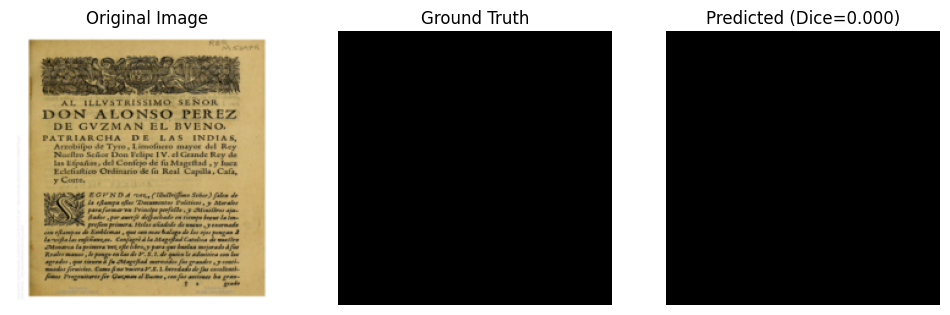

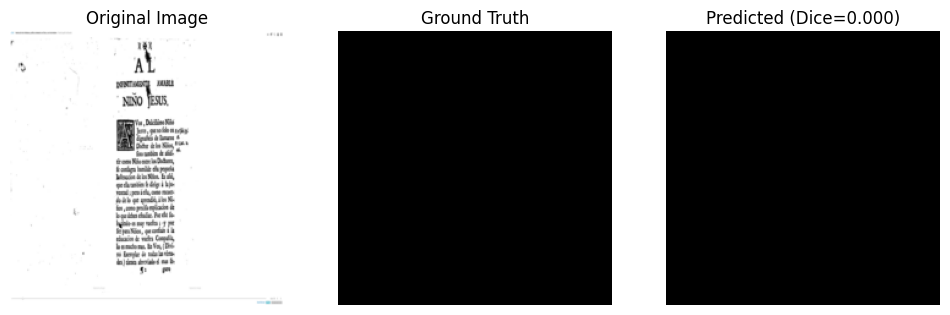

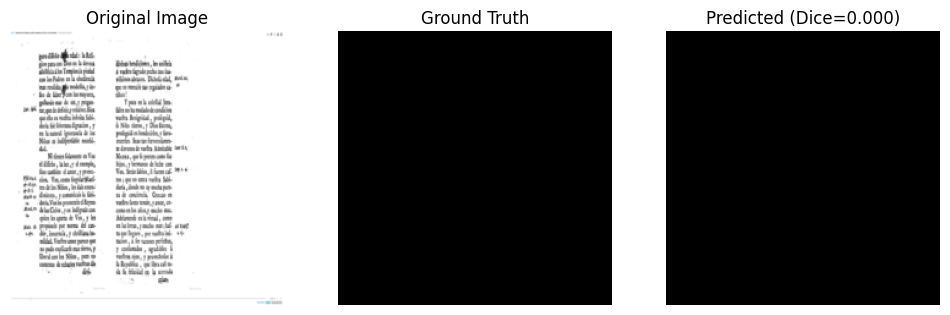

In [27]:
import torch
import matplotlib.pyplot as plt

def dice_coefficient_torch(pred, target, threshold=0.5):
    """
    传入 pred, target 均为 Torch 张量, 形状 [1,H,W]
    """
    pred_bin = (pred > threshold).float()   # 这里可以用 .float()
    target_bin = (target > threshold).float()
    
    intersection = (pred_bin * target_bin).sum()
    union = pred_bin.sum() + target_bin.sum()
    dice = (2.0 * intersection) / (union + 1e-6)
    return dice.item()

def visualize_predictions(model, loader, device, max_batches=1, threshold=0.5):
    model.eval()
    batch_count = 0
    with torch.no_grad():
        for imgs, masks in loader:
            imgs, masks = imgs.to(device), masks.to(device)
            logits = model(imgs)
            probs = torch.sigmoid(logits)  # [B,1,H,W]
            
            batch_size = imgs.size(0)
            for i in range(batch_size):
                # 这里不转 numpy, 保持张量
                img_t   = imgs[i]   # [3,H,W], float tensor
                mask_gt = masks[i]  # [1,H,W]
                prob_pred = probs[i] # [1,H,W]
                
                # Dice 用 torch 逻辑
                dice_val = dice_coefficient_torch(prob_pred, mask_gt, threshold)
                
                # 可视化时再把它们转 numpy
                img_np = img_t.detach().cpu().numpy()  # => [3,H,W]
                mask_gt_np = mask_gt.detach().cpu().numpy()[0]
                mask_pred_np = (prob_pred.detach().cpu().numpy()[0] > threshold).astype(np.float32)
                
                # 画图
                img_np = img_np.transpose(1,2,0)  # => [H,W,3]
                
                plt.figure(figsize=(12,4))
                plt.subplot(1,3,1)
                plt.imshow(img_np)
                plt.title("Original Image")
                plt.axis('off')
                
                plt.subplot(1,3,2)
                plt.imshow(mask_gt_np, cmap='gray')
                plt.title("Ground Truth")
                plt.axis('off')
                
                plt.subplot(1,3,3)
                plt.imshow(mask_pred_np, cmap='gray')
                plt.title(f"Predicted (Dice={dice_val:.3f})")
                plt.axis('off')
                
                plt.show()
            
            batch_count += 1
            if batch_count >= max_batches:
                break


# ========== 下面是示例调用 ==========

# 比如我们想可视化测试集前 2 个批次 (如果数据量不大, 1~2 个批次就够)
visualize_predictions(
    model=model,         # 你训练好的模型
    loader=test_loader,  # 测试集DataLoader
    device=device,
    max_batches=2,       # 可视化前2个批次
    threshold=0.5        # 二值化阈值
)


In [28]:
# 定义模型（ViT + Head）

# Backbone（主干）：ViT 主要负责把图像“看懂”——提取特征。
# Head（头）：指模型最后几层，用来输出你想要的结果。
# 在分割任务里，“头”通常是一些卷积或上采样层，把特征图转换成与原图同大小的分割结果。



In [29]:
# 训练与验证

# 用你自定义的 DataLoader（基于上面的 Dataset）迭代数据。
# 送入模型，计算损失函数（比如交叉熵、BCE 等）。
# 反向传播、更新模型参数。
# 观察损失是否下降，用验证集做指标（如 Dice、IoU），看效果是否提升。

In [30]:
# 评估 & 可视化

# 在测试集上推理，计算指标。
# 可视化看看预测的分割图是否跟真实标注接近。

In [31]:
3. Crop the main text


SyntaxError: invalid syntax (1615470876.py, line 1)

In [ ]:
4. OCR Recognition


In [ ]:
5. Validation